# Simple convolutional neural network for image classification: fashion-MNIST

This notebook shows a model for reaching 93.43% accuracy for fashion-mnist. I tried to create a simple conv net without extremly deep network. Furthermore I evaluate the generalization of the network for classify tradional MNIST at the end.

Some informations about the evaluation: I splitted the training set in train and validation. The testset of 10k images are used for final evaluation. I created 5 models with the same architecture but with random train/validation data. I only saved the weights of the model with best loss. Finally I used the models and evaluate them with the testset. The average accuracy of the 5 models is the final result of 93.43% accuracy.

#### Required data
You can find the dataset and further informations at Zalando:
- https://github.com/zalandoresearch/fashion-mnist
<br>Thanks to [Han](https://github.com/hanxiao) and [Kashif](https://github.com/kashif) for the great dataset.

<br>
The famous mnist by Yann LeCun:
- http://yann.lecun.com/exdb/mnist/

_______

If you have any questions or hints, please contact me through an issue. Thanks!<br>
Author: [Christopher Masch](https://github.com/cmasch)

_________

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import codecs, cv2, datetime, glob, itertools, keras, os, pickle, re, sklearn, string, sys, tensorflow, time 
from random import randint
from keras import backend as K, regularizers, optimizers
from keras.models import load_model, Sequential
from keras.layers import MaxPooling2D, Convolution2D, Activation, Dropout, Flatten, Dense, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print('Keras version: \t\t%s' % keras.__version__)
print('OpenCV version: \t%s' % cv2.__version__)
print('Scikit version: \t%s' % sklearn.__version__)
print('TensorFlow version: \t%s' % tensorflow.__version__)

Using TensorFlow backend.


Keras version: 		2.0.8
OpenCV version: 	3.3.0
Scikit version: 	0.18.1
TensorFlow version: 	1.1.0


#### Parameter

In [2]:
K.set_image_dim_ordering('tf')

#######################
# Dimension of images #
#######################
img_width  = 28
img_height = 28
channels   = 1

######################
# Parms for learning #
######################
batch_size = 250
num_epochs = 80
iterations = 5             # Number of iterations / models
number_of_augmentation = 2 # defines the amount of additional augmentation images of one image
early_stopping = EarlyStopping(monitor='val_loss', patience=5) # Early stopping on validation loss - not used

####################
#       Data       #
####################
train_data_dir      = 'data/train/fashion_mnist'
test_data_dir       = 'data/test/fashion_mnist'
classes             = {0: 'T-shirt/top', 
                       1: 'Trouser', 
                       2: 'Pullover', 
                       3: 'Dress', 
                       4: 'Coat',
                       5: 'Sandal', 
                       6: 'Shirt', 
                       7: 'Sneaker', 
                       8: 'Bag', 
                       9: 'Ankle boot'
                      }
num_classes         = len(classes)
classes_fashion     = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

#### Model definition

In [3]:
def create_model():
    '''
    Creates a sequential model
    '''
    
    cnn = Sequential()
    
    cnn.add(InputLayer(input_shape=(img_height,img_width,1)))
    
    # Normalization
    cnn.add(BatchNormalization())
    
    # Conv + Maxpooling
    cnn.add(Convolution2D(64, (4, 4), padding='same', input_shape=(img_height, img_width, channels), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(Dropout(0.1))
    
    # Conv + Maxpooling
    cnn.add(Convolution2D(64, (4, 4), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(Dropout(0.3))

    # Converting 3D feature to 1D feature Vektor
    cnn.add(Flatten())

    # Fully Connected Layer
    cnn.add(Dense(256, activation='relu'))

    # Dropout
    cnn.add(Dropout(0.5))
    
    # Fully Connected Layer
    cnn.add(Dense(64, activation='relu'))
    
    # Normalization
    cnn.add(BatchNormalization())

    cnn.add(Dense(num_classes, activation='softmax'))
    cnn.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

    return cnn

create_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
__________

#### Data augmentation (optional)
This method will increase the raw data by data augmentation of images. I just added rotation, horizontal flip and fill mode.

In [4]:
# Defines the options for augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    fill_mode='nearest'
)

def image_augmentation(image):
    '''
    Generates new images bei augmentation
    image : raw image reading in by cv2.imread()
    images: array with new images
    '''
    images = []
    image = image.reshape(1, img_height, img_width, channels)
    i = 0
    for x_batch in datagen.flow(image, batch_size=1):
        images.append(x_batch)
        i += 1
        if i >= number_of_augmentation:
            break
    return images

#### Reading data
I already extract the images of the IDX files. If you need an example how to extract the images, please take a look at [this example](https://github.com/cmasch/zalando-fashion-mnist/blob/master/Extracting_MNIST.ipynb) with the helper function `extract_mnist()`

In [5]:
def load_data(path, use_augmentation=True):
    X = []
    y = []
    print('-- Reading path: {} --'.format(path))
    for j in range(num_classes):
        print('  Load folder {}...'.format(j))
        sub_path = os.path.join(path,str(j), '*g')
        files = glob.glob(sub_path)
        for image in files:
            img = cv2.imread(image, 0)
            
            # DATA AUGMENTATION
            if use_augmentation:
                argu_img = image_augmentation(img)
                for a in argu_img:
                    X.append(a.reshape(img_height, img_width))
                    y.append(j)
                    
            X.append(img)
            y.append(j)
    print('*Reading complete: %i samples\n' % len(X))
    return X, y

In [6]:
train_data, train_target = load_data(train_data_dir)
test_data, test_target   = load_data(test_data_dir, False)

-- Reading path: data/train/fashion_mnist --
  Load folder 0...
  Load folder 1...
  Load folder 2...
  Load folder 3...
  Load folder 4...
  Load folder 5...
  Load folder 6...
  Load folder 7...
  Load folder 8...
  Load folder 9...
*Reading complete: 180000 samples

-- Reading path: data/test/fashion_mnist --
  Load folder 0...
  Load folder 1...
  Load folder 2...
  Load folder 3...
  Load folder 4...
  Load folder 5...
  Load folder 6...
  Load folder 7...
  Load folder 8...
  Load folder 9...
*Reading complete: 10000 samples



##### Preparing the data
Shaping the data

In [7]:
def shaping(data, target):
    data = np.array(data, dtype=np.uint8)
    target = np.array(target, dtype=np.uint8)
    data = data.reshape(data.shape[0], img_height, img_width, channels)
    target = np_utils.to_categorical(target, num_classes)
    data = data.astype('float32')
    data /= 255
    return data, target

In [8]:
train_data_shaped, train_target_shaped  = shaping(train_data, train_target)
test_data_shaped, test_target_shaped    = shaping(test_data, test_target)

##### Running training with splitting of training data
Running training for number of iterations by random data for train/validation. The best model of each iteration will be saved as a hdf5 checkpoint.
While evaluation I disabled early stopping to get informations about overfitting.

In [9]:
histories = []

for i in range(0,iterations):
    print('Running iteration: %i' % i)
    
    # Saving the best checkpoint for each iteration
    filepath="models/simple_cnn/fashion_mnist/fashion_mnist-%i.hdf5" % i
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    X_train, X_val, y_train, y_val = train_test_split(train_data_shaped, train_target_shaped, test_size=0.2, random_state=42)
    
    cnn = create_model()
    history = cnn.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        verbose=1,
        validation_data=(X_val, y_val),
        callbacks=[
            #early_stopping,
            checkpoint
        ]
    )
    
    histories.append(history.history)

Running iteration: 0
Train on 144000 samples, validate on 36000 samples
Epoch 1/80
  5500/144000 [>.............................] - ETA: 484s - loss: 1.6858 - acc: 0.4113

#### Saving histories
It takes a lot of time to run this neural network on CPU (10h / one iteration). Therefore I saved the history of training on disk.

In [10]:
with open('models/simple_cnn/fashion_mnist/fashion_mnist-history.pkl', 'wb') as f:
    pickle.dump(histories, f)

# Evaluation

#### Loading histories
Loading saved histories

In [11]:
histories = pickle.load(open('models/simple_cnn/fashion_mnist/fashion_mnist.pkl', 'rb'))

#### Trainingscores for loss and accuracy for all checkpoints
Please remind that checkpoints will be saved by minimum loss.

In [12]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.8f loss / %0.8f acc' % (get_avg(histories, 'loss'), get_avg(histories, 'acc')))
print('Validation: \t%0.8f loss / %0.8f acc' % (get_avg(histories, 'val_loss'), get_avg(histories, 'val_acc')))

Training: 	0.10659398 loss / 0.95990277 acc
Validation: 	0.12458680 loss / 0.95646666 acc


#### Loss / accuracy of all models (iterations) on testset
Determine loss and accuracy of all models.

In [13]:
test_loss = []
test_accs = []

for i in range(0,iterations):
    cnn_ = create_model()
    cnn_.load_weights("models/simple_cnn/fashion_mnist/fashion_mnist-%i.hdf5" % i) # loading checkpoint / iteration
    
    score = cnn_.evaluate(test_data_shaped, test_target_shaped, verbose=0)
    test_loss.append(score[0])
    test_accs.append(score[1])
    
    print('Running final test with model %i: %0.4f loss / %0.4f acc' % (i, score[0], score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.5f acc' % (np.mean(test_loss), np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss), np.std(test_accs)))

Running final test with model 0: 0.2104 loss / 0.9340 acc
Running final test with model 1: 0.2196 loss / 0.9346 acc
Running final test with model 2: 0.2172 loss / 0.9348 acc
Running final test with model 3: 0.2148 loss / 0.9344 acc
Running final test with model 4: 0.2122 loss / 0.9336 acc

Average loss / accuracy on testset: 0.2149 loss / 0.93428 acc
Standard deviation: (+-0.0033) loss / (+-0.0004) acc


##### Plotting accuracy and loss for each iteration

In [14]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % i)
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='upper left')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

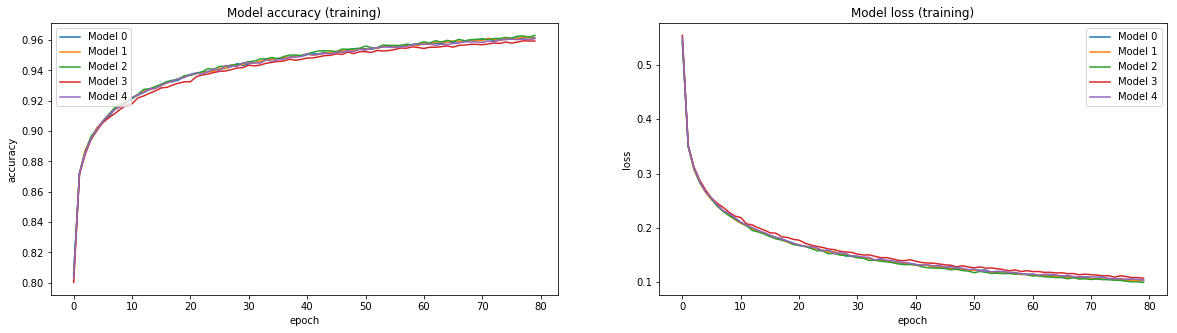

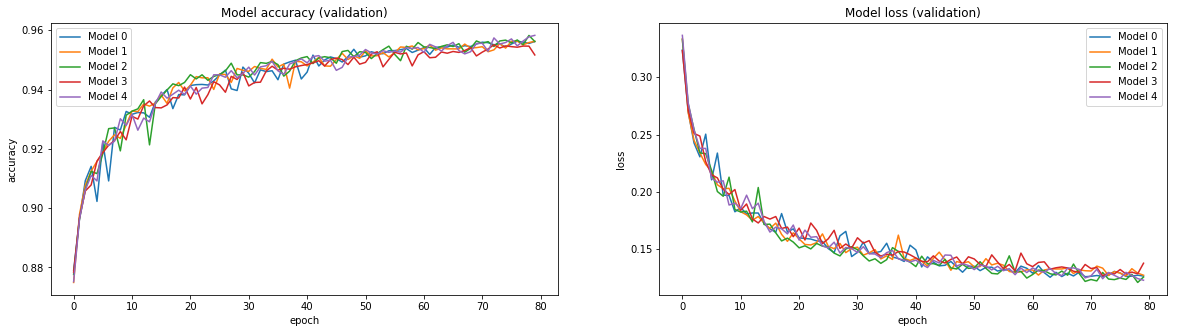

In [15]:
plot_acc_loss('training', histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')

## Evaluation for one model

In [16]:
RUN = 0 # you can choose one of the different models trained above
model = create_model()
model.load_weights("models/simple_cnn/fashion_mnist/fashion_mnist-%i.hdf5" % RUN)
predictions = model.predict_classes(test_data_shaped, verbose=0)

##### Plotting accuracy and loss for one model

In [17]:
def plot_train_val(title, history):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Accuracy
    ax1.set_title('Model accuracy - %s' % title)
    ax1.plot(history['acc'])
    ax1.plot(history['val_acc'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')

    # Loss
    ax2.set_title('Model loss - %s' % title)
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['train', 'validation'], loc='upper left')

    fig.set_size_inches(20, 5)
    plt.show()

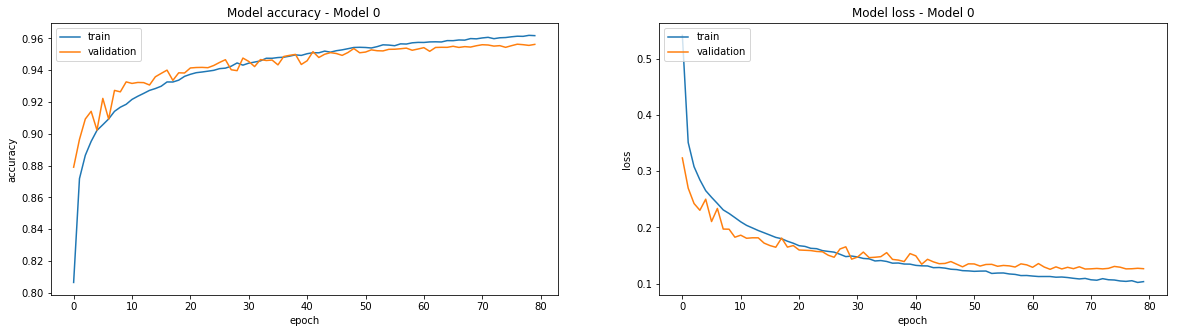

In [18]:
plot_train_val('Model %i' % RUN, histories[RUN])

##### Displaying results of random predictions

In [19]:
def plot_sample_predictions(classes, model, X_test, y_test):
    """
    This function displays images randomly and tries to predict the correct class
    """

    class_ = 0
    images_per_row = 5
    rows = len(classes) / images_per_row

    for i in range(rows):
        fig, axis = plt.subplots(1, images_per_row)

        for i, axis in enumerate(axis):
            start = y_test[::1].index(class_)
            end   = len(y_test) - y_test[::-1].index(class_) - 1
            random = randint(start, end)
            X = X_test[random]
            y = y_test[random]
            X_shaped, _ = shaping([X_test[random]], [y_test[random]])

            fig.set_size_inches(10, 20)
            axis.text(0,32,'Predicted: {}'.format(classes[np.argmax(model.predict(X_shaped))]))
            axis.text(0,36,'Correct: {}'.format((classes)[y]))
            axis.imshow(X, cmap='gray')
            axis.axis('off')
            class_ +=1
    plt.show()

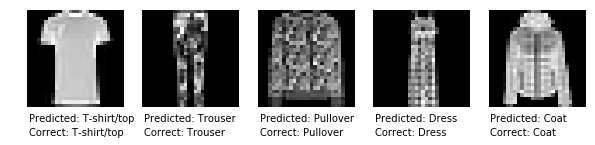

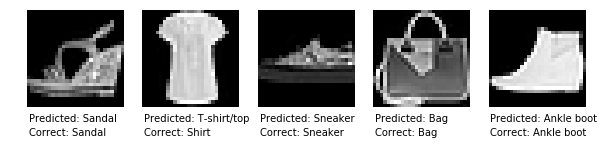

In [20]:
plot_sample_predictions(classes_fashion, model, test_data, test_target)

##### Plotting confusion matrix

In [21]:
def plot_confusion_matrix(cm,class_,title='Confusion matrix',cmap=plt.cm.Reds):
    """
    This function plots a confusion matrix
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(class_))
    plt.xticks(tick_marks, class_, rotation=90)
    plt.yticks(tick_marks, class_)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()

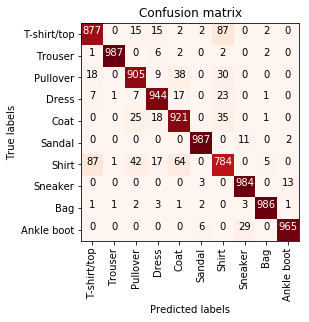

In [22]:
plot_confusion_matrix(confusion_matrix(test_target, predictions), classes_fashion)

##### Report with f1, prec, rec

In [23]:
print classification_report(test_target, predictions)

             precision    recall  f1-score   support

          0       0.88      0.88      0.88      1000
          1       1.00      0.99      0.99      1000
          2       0.91      0.91      0.91      1000
          3       0.93      0.94      0.94      1000
          4       0.88      0.92      0.90      1000
          5       0.99      0.99      0.99      1000
          6       0.82      0.78      0.80      1000
          7       0.96      0.98      0.97      1000
          8       0.99      0.99      0.99      1000
          9       0.98      0.96      0.97      1000

avg / total       0.93      0.93      0.93     10000



____________
____________

# MNIST

#### Reading MNIST data

In [24]:
train_data_dir = 'data/train/mnist'
test_data_dir = 'data/test/mnist'

train_data_mnist, train_target_mnist = load_data(train_data_dir)
test_data_mnist, test_target_mnist   = load_data(test_data_dir, False)

train_data_shape_mnist, train_target_shape_mnist = shaping(train_data_mnist, train_target_mnist)
test_data_shape_mnist, test_target_shape_mnist   = shaping(test_data_mnist, test_target_mnist)

-- Reading path: data/train/mnist --
  Load folder 0...
  Load folder 1...
  Load folder 2...
  Load folder 3...
  Load folder 4...
  Load folder 5...
  Load folder 6...
  Load folder 7...
  Load folder 8...
  Load folder 9...
*Reading complete: 180000 samples

-- Reading path: data/test/mnist --
  Load folder 0...
  Load folder 1...
  Load folder 2...
  Load folder 3...
  Load folder 4...
  Load folder 5...
  Load folder 6...
  Load folder 7...
  Load folder 8...
  Load folder 9...
*Reading complete: 10000 samples



#### Training model on MNIST

In [25]:
cnn_mnist = create_model()

X_train, X_val, y_train, y_val = train_test_split(train_data_shape_mnist, train_target_shape_mnist, test_size=0.2, random_state=42)

# Used for saving the best checkpoint
filepath="models/simple_cnn/mnist/mnist.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history_mnist_raw = cnn_mnist.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[
        #early_stopping,
        checkpoint
        ]
)

# Saving one history
with open('models/simple_cnn/mnist/mnist-history.pkl', 'wb') as f:
    pickle.dump(history_mnist_raw.history, f)

Train on 144000 samples, validate on 36000 samples
Epoch 1/80
  1750/144000 [..............................] - ETA: 497s - loss: 2.4451 - acc: 0.1931

### Evaluation

#### Final test

In [26]:
mnist_model = create_model()
mnist_model.load_weights("models/simple_cnn/mnist/mnist.hdf5")

score = mnist_model.evaluate(test_data_shape_mnist, test_target_shape_mnist, verbose=0)
pred  = mnist_model.predict_classes(test_data_shape_mnist, verbose=0)
print('Running final test: %0.4f loss / %0.4f acc' % (score[0], score[1]))

Running final test: 0.0248 loss / 0.9943 acc


#### Plotting some metrics

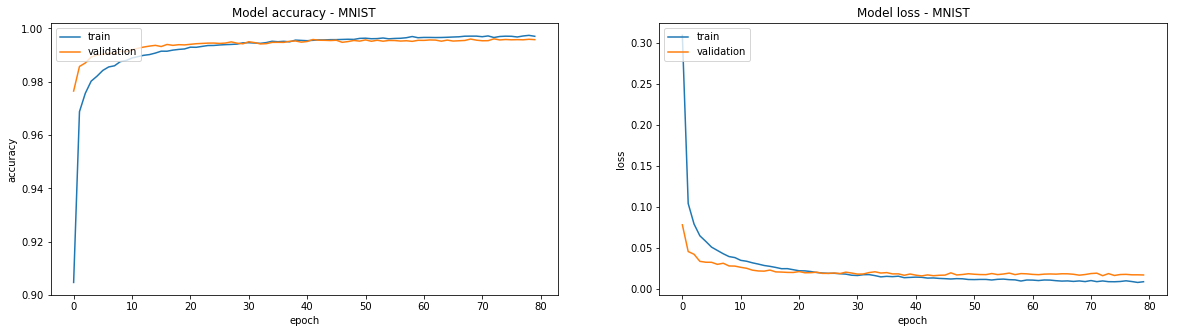

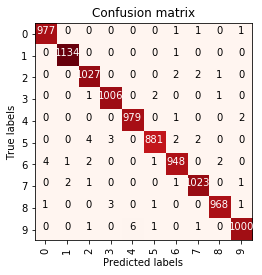

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       980
          1       1.00      1.00      1.00      1135
          2       0.99      1.00      0.99      1032
          3       0.99      1.00      1.00      1010
          4       0.99      1.00      1.00       982
          5       0.99      0.99      0.99       892
          6       0.99      0.99      0.99       958
          7       0.99      1.00      0.99      1028
          8       1.00      0.99      0.99       974
          9       1.00      0.99      0.99      1009

avg / total       0.99      0.99      0.99     10000



In [27]:
# Loading history
history_mnist = pickle.load(open('models/simple_cnn/mnist/mnist-history.pkl', 'rb'))
classes_mnist = [0,1,2,3,4,5,6,7,8,9]

plot_train_val('MNIST', history_mnist)
plot_confusion_matrix(confusion_matrix(test_target_mnist, pred), classes_mnist)
print classification_report(test_target_mnist, pred)

#### Examples

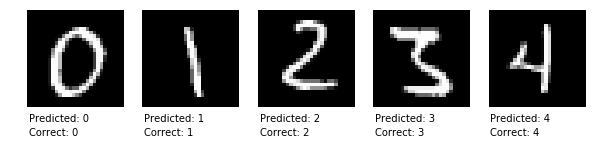

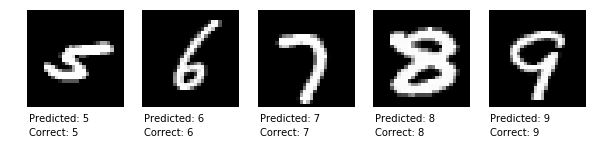

In [28]:
plot_sample_predictions(classes_mnist, mnist_model, test_data_mnist, test_target_mnist)